# Processing Nova project for number of commits and churn
## by Amirreza Shamsolhodaei

In this script, Git repository of the OpenStack Nova Project(located at [here](https://github.com/openstack/nova)) is mined for the number of commits and churn in the top 12 active modules at [nova subdirectory](https://github.com/openstack/nova/tree/master/nova) in the last six months (since 10th of May 2021).
The library that is used for mining informations from the repository is Pydriller (Documentations at [here](https://pydriller.readthedocs.io/en/latest/tutorial.html)) and the library that is used for processing the information is Pandas (Documentations at [here](https://pandas.pydata.org/)).
## Sections:
1. [Importing the required libraries and modules](##Importing-the-required-libraries-and-modules:)
2. [Getting the information from the repostitory](##Getting-the-information-from-the-repostitory)
3. [Processing the information](##Processing-the-information)
4. [Getting the activity indicators for modules in nova](##Getting-the-activity-indicators-for-modules-in-nova)
5. [Identifying and plotting the top 12 actively modified modules](##Identifying-and-plotting-the-top-12-actively-modified-modules)







## 1. Importing the required libraries and modules:
   in this section, the required libraries and modules such as Pydriller and Pandas are imported.

In [122]:
from datetime import datetime
import pydriller
from pydriller.domain.commit import ModifiedFile
import git
from pydriller.metrics.process.commits_count import CommitsCount
from pydriller import Repository
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

## 2. Getting the information from the repostitory
At first, a set of lists are created to hold the information, in the next part, the modules that are needed are filtered.

In [156]:
Hash = []
fileName = []
AddedLines = []
removedLines = []
date = []
churn = []
filePath = []
def directory_split(a):
    if a.count("\\") == 1:
        return a
    return "\\".join(a.split("\\", 2)[:2])

Using Pydriller, the information that is needed is stored at the created listsand is printed out. Note that in my own testings, I cloned the repository in my own Hard Drive due to the complications with Internet speed. but in the code below, the link to the repository is stated.

In [157]:
for commit in Repository(path_to_repo="E:/Programming/GitHub/nova",since = datetime(2021, 5, 10)).traverse_commits() :
            for m in commit.modified_files:
                try:
                    path = os.path.dirname(m.new_path)
                    path = directory_split(path)
                except:
                    path = os.path.dirname(m.old_path)
                    path = directory_split(path)
                #try:
                #    path = os.path.dirname(m.new_path)
                #except:
                #    path = os.path.dirname(m.old_path)
                vchurn = m.added_lines + m.deleted_lines
                print(f"Date: {commit.committer_date} path: {path} modified : {m.filename} Commit Hash: {commit.hash} Added Lines:{m.added_lines} deleted lines: {m.deleted_lines} churn : {vchurn}")
                Hash.append(commit.hash)
                fileName.append(m.filename)
                AddedLines.append(m.added_lines)
                removedLines.append(m.deleted_lines)
                date.append(commit.committer_date)
                churn.append(vchurn)
                filePath.append(path)


Date: 2021-05-10 15:04:31-04:00 path: nova\tests modified : test_utils.py Commit Hash: 251e601a4d86b487723b5297abf38b967def3d5e Added Lines:3 deleted lines: 3 churn : 6
Date: 2021-05-10 19:18:30+00:00 path: nova\tests modified : __init__.py Commit Hash: 8b647f1b3f56879be221b3925570790a1e0e77f8 Added Lines:0 deleted lines: 0 churn : 0
Date: 2021-05-10 19:18:30+00:00 path: nova\tests modified : test_rbd.py Commit Hash: 8b647f1b3f56879be221b3925570790a1e0e77f8 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-05-11 17:28:56+02:00 path: nova\storage modified : rbd_utils.py Commit Hash: 86af7feed06f08ddb3ef65122089216708d53a06 Added Lines:8 deleted lines: 1 churn : 9
Date: 2021-05-11 17:28:56+02:00 path: nova\tests modified : test_rbd.py Commit Hash: 86af7feed06f08ddb3ef65122089216708d53a06 Added Lines:6 deleted lines: 0 churn : 6
Date: 2021-05-12 10:50:52+08:00 path: nova\cmd modified : common.py Commit Hash: 150b9182512fa0a4f157586e040a7f67c1851005 Added Lines:2 deleted lines: 2 churn :

Date: 2021-05-14 17:26:00+02:00 path: nova\console modified : websocketproxy.py Commit Hash: 781612b33282ed298f742c85dab58a075c8b793e Added Lines:23 deleted lines: 0 churn : 23
Date: 2021-05-14 17:26:00+02:00 path: nova\tests modified : test_websocketproxy.py Commit Hash: 781612b33282ed298f742c85dab58a075c8b793e Added Lines:34 deleted lines: 0 churn : 34
Date: 2021-05-14 17:26:00+02:00 path: releasenotes\notes modified : console-proxy-reject-open-redirect-4ac0a7895acca7eb.yaml Commit Hash: 781612b33282ed298f742c85dab58a075c8b793e Added Lines:19 deleted lines: 0 churn : 19
Date: 2021-05-18 22:54:57+09:00 path:  modified : tox.ini Commit Hash: 74724b4964b6eb80a462458c7b04935ccae49710 Added Lines:2 deleted lines: 2 churn : 4
Date: 2021-05-19 10:29:56+02:00 path:  modified : lower-constraints.txt Commit Hash: 0d84833e9688e0df97f3d24e06025e512bca3ce3 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-05-19 10:29:56+02:00 path: nova\conf modified : libvirt.py Commit Hash: 0d84833e9688e0df97

Date: 2021-05-24 11:00:59+01:00 path: nova\tests modified : test_driver.py Commit Hash: 696fbab9e1a96841b0acd1d5530b59e4c7878c00 Added Lines:24 deleted lines: 24 churn : 48
Date: 2021-05-24 11:00:59+01:00 path: nova\tests modified : test_virt_drivers.py Commit Hash: 696fbab9e1a96841b0acd1d5530b59e4c7878c00 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-05-24 11:00:59+01:00 path: nova\tests modified : __init__.py Commit Hash: f1f599d098c2dcb307bfab074060855c703a8288 Added Lines:1 deleted lines: 0 churn : 1
Date: 2021-05-24 11:00:59+01:00 path: nova\tests modified : notifications.py Commit Hash: f1f599d098c2dcb307bfab074060855c703a8288 Added Lines:39 deleted lines: 0 churn : 39
Date: 2021-05-24 11:00:59+01:00 path: nova\tests modified : test_cache_image.py Commit Hash: f1f599d098c2dcb307bfab074060855c703a8288 Added Lines:6 deleted lines: 6 churn : 12
Date: 2021-05-24 11:00:59+01:00 path: nova\tests modified : test_init_host.py Commit Hash: f1f599d098c2dcb307bfab074060855c703a8288 Ad

Date: 2021-05-26 17:26:05+01:00 path: nova\tests modified : libvirt_data.py Commit Hash: 740e6f09bf5a3e5ab3c6dd6d412dd1fe33f81d9f Added Lines:3 deleted lines: 1 churn : 4
Date: 2021-05-26 17:26:05+01:00 path: nova\tests modified : test_driver.py Commit Hash: 740e6f09bf5a3e5ab3c6dd6d412dd1fe33f81d9f Added Lines:14 deleted lines: 6 churn : 20
Date: 2021-05-26 17:26:05+01:00 path: nova\virt modified : config.py Commit Hash: 740e6f09bf5a3e5ab3c6dd6d412dd1fe33f81d9f Added Lines:6 deleted lines: 0 churn : 6
Date: 2021-05-26 17:26:05+01:00 path: nova\virt modified : driver.py Commit Hash: 740e6f09bf5a3e5ab3c6dd6d412dd1fe33f81d9f Added Lines:9 deleted lines: 0 churn : 9
Date: 2021-05-26 17:26:05+01:00 path: releasenotes\notes modified : libvirt-vmcoreinfo-3be69e21dfe7dbd2.yaml Commit Hash: 740e6f09bf5a3e5ab3c6dd6d412dd1fe33f81d9f Added Lines:10 deleted lines: 0 churn : 10
Date: 2021-05-26 19:35:29+01:00 path:  modified : .zuul.yaml Commit Hash: d5ed968826895d362f4f2aa21decfdebb9b1fd84 Added Li

Date: 2021-06-10 11:00:22+02:00 path:  modified : tox.ini Commit Hash: 531fa4cd04ca1b8ee869f95d427ea26df0852541 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-06-10 18:07:47+02:00 path: nova\tests modified : __init__.py Commit Hash: 7085770b2019ec97ef28063f48048f99c3087278 Added Lines:0 deleted lines: 0 churn : 0
Date: 2021-06-10 18:07:47+02:00 path: nova\tests modified : test_notifications.py Commit Hash: 7085770b2019ec97ef28063f48048f99c3087278 Added Lines:9 deleted lines: 10 churn : 19
Date: 2021-06-10 18:07:47+02:00 path: nova\tests modified : notifications.py Commit Hash: d71dfa8b8d7f3e170a0ff66064bdf950a787a028 Added Lines:171 deleted lines: 8 churn : 179
Date: 2021-06-10 18:07:47+02:00 path: nova\tests modified : fake_notifier.py Commit Hash: d71dfa8b8d7f3e170a0ff66064bdf950a787a028 Added Lines:0 deleted lines: 153 churn : 153
Date: 2021-06-11 11:47:28+02:00 path:  modified : tox.ini Commit Hash: 47bedbb77a95308bc585a7d40fcb343257e4ce0b Added Lines:1 deleted lines: 1 churn 

Date: 2021-06-18 12:34:22+01:00 path: nova\objects modified : instance_numa.py Commit Hash: 387823b36d091abbaa37efb930fc98b94a5bbb93 Added Lines:2 deleted lines: 0 churn : 2
Date: 2021-06-18 12:34:22+01:00 path: nova\tests modified : test_numa_servers.py Commit Hash: 387823b36d091abbaa37efb930fc98b94a5bbb93 Added Lines:9 deleted lines: 18 churn : 27
Date: 2021-06-18 12:34:22+01:00 path: nova\tests modified : test_hardware.py Commit Hash: 387823b36d091abbaa37efb930fc98b94a5bbb93 Added Lines:20 deleted lines: 161 churn : 181
Date: 2021-06-18 12:34:22+01:00 path: nova\virt modified : hardware.py Commit Hash: 387823b36d091abbaa37efb930fc98b94a5bbb93 Added Lines:4 deleted lines: 125 churn : 129
Date: 2021-06-18 12:34:22+01:00 path: nova\virt modified : driver.py Commit Hash: 387823b36d091abbaa37efb930fc98b94a5bbb93 Added Lines:1 deleted lines: 2 churn : 3
Date: 2021-06-18 12:34:22+01:00 path: releasenotes\notes modified : bug-1910466-max-vcpu-topologies-with-numa-9a9ceb1b0fc7c33d.yaml Commi

Date: 2021-07-05 11:04:42+01:00 path: nova\cmd modified : status.py Commit Hash: 43de2421b37e5e91418819f728c56bc56fa8d7ed Added Lines:9 deleted lines: 8 churn : 17
Date: 2021-07-05 11:04:42+01:00 path: nova\db modified : api.py Commit Hash: 43de2421b37e5e91418819f728c56bc56fa8d7ed Added Lines:107 deleted lines: 107 churn : 214
Date: 2021-07-05 11:04:42+01:00 path: nova\db modified : api_models.py Commit Hash: 43de2421b37e5e91418819f728c56bc56fa8d7ed Added Lines:306 deleted lines: 287 churn : 593
Date: 2021-07-05 11:04:42+01:00 path: nova\db modified : models.py Commit Hash: 43de2421b37e5e91418819f728c56bc56fa8d7ed Added Lines:603 deleted lines: 581 churn : 1184
Date: 2021-07-05 11:04:42+01:00 path: nova\objects modified : aggregate.py Commit Hash: 43de2421b37e5e91418819f728c56bc56fa8d7ed Added Lines:13 deleted lines: 14 churn : 27
Date: 2021-07-05 11:04:42+01:00 path: nova\objects modified : cell_mapping.py Commit Hash: 43de2421b37e5e91418819f728c56bc56fa8d7ed Added Lines:9 deleted lin

Date: 2021-07-05 11:05:04+01:00 path: nova\db modified : 402_train.py Commit Hash: 089ae234a7ce4edaa63e135fc2de6a0c4efcb0c2 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-07-05 11:05:04+01:00 path: nova\db modified : models.py Commit Hash: 089ae234a7ce4edaa63e135fc2de6a0c4efcb0c2 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-07-05 11:05:04+01:00 path: nova\db modified : types.py Commit Hash: 089ae234a7ce4edaa63e135fc2de6a0c4efcb0c2 Added Lines:0 deleted lines: 0 churn : 0
Date: 2021-07-05 11:05:04+01:00 path: nova\tests modified : test_db_api.py Commit Hash: 089ae234a7ce4edaa63e135fc2de6a0c4efcb0c2 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-07-05 11:10:09+01:00 path: nova\cmd modified : manage.py Commit Hash: 014480d52fce238b36ab5750f36c9ab4ece4a6d2 Added Lines:3 deleted lines: 2 churn : 5
Date: 2021-07-05 11:10:09+01:00 path: nova\compute modified : flavors.py Commit Hash: 014480d52fce238b36ab5750f36c9ab4ece4a6d2 Added Lines:9 deleted lines: 8 churn : 17
Date: 2021

Date: 2021-07-28 14:55:19+02:00 path: nova\tests modified : test_services.py Commit Hash: 32257a2a6d159406577c885a9d7e366cbf0c72b9 Added Lines:19 deleted lines: 0 churn : 19
Date: 2021-07-28 14:57:36+02:00 path: nova\api modified : services.py Commit Hash: 880611df0b6b967adabd3f08886e385d0a100c5c Added Lines:19 deleted lines: 4 churn : 23
Date: 2021-07-28 14:57:36+02:00 path: nova\tests modified : test_services.py Commit Hash: 880611df0b6b967adabd3f08886e385d0a100c5c Added Lines:1 deleted lines: 5 churn : 6
Date: 2021-07-28 19:54:29+00:00 path: nova\virt modified : driver.py Commit Hash: f916266d4f5949d1501319a916d6e005d47efd58 Added Lines:4 deleted lines: 6 churn : 10
Date: 2021-07-29 12:46:28+01:00 path: nova\tests modified : test_servers.py Commit Hash: 48f35058fe6f821644b4b188a1273a4d8e547d78 Added Lines:0 deleted lines: 1 churn : 1
Date: 2021-07-29 12:46:28+01:00 path: nova\tests modified : fakes.py Commit Hash: 48f35058fe6f821644b4b188a1273a4d8e547d78 Added Lines:0 deleted lines:

Date: 2021-08-05 15:58:34+08:00 path: nova\compute modified : manager.py Commit Hash: e19fa1a1997c6d18d440dcdc5a0732b7e2467fa5 Added Lines:11 deleted lines: 2 churn : 13
Date: 2021-08-05 15:58:34+08:00 path: nova\compute modified : utils.py Commit Hash: e19fa1a1997c6d18d440dcdc5a0732b7e2467fa5 Added Lines:22 deleted lines: 10 churn : 32
Date: 2021-08-05 15:58:34+08:00 path: nova\conductor modified : manager.py Commit Hash: e19fa1a1997c6d18d440dcdc5a0732b7e2467fa5 Added Lines:7 deleted lines: 1 churn : 8
Date: 2021-08-05 15:58:34+08:00 path: nova\network modified : neutron.py Commit Hash: e19fa1a1997c6d18d440dcdc5a0732b7e2467fa5 Added Lines:9 deleted lines: 1 churn : 10
Date: 2021-08-05 15:58:34+08:00 path: nova\tests modified : test_compute_mgr.py Commit Hash: e19fa1a1997c6d18d440dcdc5a0732b7e2467fa5 Added Lines:6 deleted lines: 1 churn : 7
Date: 2021-08-05 15:58:34+08:00 path: nova\tests modified : test_compute_utils.py Commit Hash: e19fa1a1997c6d18d440dcdc5a0732b7e2467fa5 Added Lines

Date: 2021-08-09 15:34:40+01:00 path: doc\source modified : upgrade.rst Commit Hash: bf8b5fc7d05e0a66031a03e50e8f6bb76a921046 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : README Commit Hash: bf8b5fc7d05e0a66031a03e50e8f6bb76a921046 Added Lines:0 deleted lines: 0 churn : 0
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : __init__.py Commit Hash: bf8b5fc7d05e0a66031a03e50e8f6bb76a921046 Added Lines:0 deleted lines: 0 churn : 0
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : manage.py Commit Hash: bf8b5fc7d05e0a66031a03e50e8f6bb76a921046 Added Lines:0 deleted lines: 0 churn : 0
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : migrate.cfg Commit Hash: bf8b5fc7d05e0a66031a03e50e8f6bb76a921046 Added Lines:0 deleted lines: 0 churn : 0
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : 067_train.py Commit Hash: bf8b5fc7d05e0a66031a03e50e8f6bb76a921046 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-08-09 15

Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : alembic.ini Commit Hash: ca9ba88a7a31e6feb906f9c84b47af2aed43c684 Added Lines:89 deleted lines: 0 churn : 89
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : 402_train.py Commit Hash: ca9ba88a7a31e6feb906f9c84b47af2aed43c684 Added Lines:0 deleted lines: 3 churn : 3
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : README.rst Commit Hash: ca9ba88a7a31e6feb906f9c84b47af2aed43c684 Added Lines:15 deleted lines: 0 churn : 15
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : env.py Commit Hash: ca9ba88a7a31e6feb906f9c84b47af2aed43c684 Added Lines:79 deleted lines: 0 churn : 79
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : script.py.mako Commit Hash: ca9ba88a7a31e6feb906f9c84b47af2aed43c684 Added Lines:36 deleted lines: 0 churn : 36
Date: 2021-08-09 15:34:40+01:00 path: nova\db modified : 8f2f1571d55b_initial_version.py Commit Hash: ca9ba88a7a31e6feb906f9c84b47af2aed43c684 Added Lines:1629 deleted lines:

Date: 2021-08-12 10:18:43+01:00 path: nova\tests modified : test_live_migration.py Commit Hash: 31bedfc09c1d35242e0b8101343f6e64ac63157d Added Lines:72 deleted lines: 10 churn : 82
Date: 2021-08-12 14:26:45+01:00 path: nova\tests modified : test_bug_1853009.py Commit Hash: 59d9871e8a0672538f8ffc43ae99b3d1c4b08909 Added Lines:190 deleted lines: 0 churn : 190
Date: 2021-08-12 14:26:45+01:00 path: nova\compute modified : manager.py Commit Hash: 32676a9f45807ea8770dc7bdff1e859673af1b61 Added Lines:2 deleted lines: 0 churn : 2
Date: 2021-08-12 14:26:45+01:00 path: nova\compute modified : resource_tracker.py Commit Hash: 32676a9f45807ea8770dc7bdff1e859673af1b61 Added Lines:17 deleted lines: 0 churn : 17
Date: 2021-08-12 14:26:45+01:00 path: nova\tests modified : test_bug_1853009.py Commit Hash: 32676a9f45807ea8770dc7bdff1e859673af1b61 Added Lines:26 deleted lines: 16 churn : 42
Date: 2021-08-12 14:26:45+01:00 path: nova\tests modified : test_compute_mgr.py Commit Hash: 32676a9f45807ea8770dc7

Date: 2021-08-19 11:21:55+01:00 path: nova\tests modified : test_servers.py Commit Hash: cb3e11952d1933aa25e302323d6d92de4dfd0247 Added Lines:91 deleted lines: 91 churn : 182
Date: 2021-08-19 11:21:55+01:00 path: nova\tests modified : test_api.py Commit Hash: cb3e11952d1933aa25e302323d6d92de4dfd0247 Added Lines:18 deleted lines: 30 churn : 48
Date: 2021-08-19 11:21:55+01:00 path: nova\tests modified : test_compute.py Commit Hash: cb3e11952d1933aa25e302323d6d92de4dfd0247 Added Lines:0 deleted lines: 11 churn : 11
Date: 2021-08-19 13:23:28+01:00 path: nova\tests modified : cinder.py Commit Hash: 8a0ae569efbed7c9ef6379fb9b4631c889096944 Added Lines:9 deleted lines: 0 churn : 9
Date: 2021-08-20 13:07:14+01:00 path: nova\tests modified : base.py Commit Hash: 78cace1ce485b2fccb66288eef5d0a13f0f84bde Added Lines:25 deleted lines: 0 churn : 25
Date: 2021-08-20 13:07:14+01:00 path: nova\tests modified : test_numa_live_migration.py Commit Hash: 78cace1ce485b2fccb66288eef5d0a13f0f84bde Added Line

Date: 2021-08-21 09:49:54+02:00 path: api-guide\source modified : port_with_resource_request.rst Commit Hash: e357ad3c2354f1c22cd5b569a2f0ec23c9c06753 Added Lines:10 deleted lines: 0 churn : 10
Date: 2021-08-21 09:49:54+02:00 path: doc\source modified : ports-with-resource-requests.rst Commit Hash: e357ad3c2354f1c22cd5b569a2f0ec23c9c06753 Added Lines:25 deleted lines: 0 churn : 25
Date: 2021-08-21 09:49:54+02:00 path: nova\api modified : servers.py Commit Hash: e357ad3c2354f1c22cd5b569a2f0ec23c9c06753 Added Lines:3 deleted lines: 1 churn : 4
Date: 2021-08-21 09:49:54+02:00 path: nova modified : exception.py Commit Hash: e357ad3c2354f1c22cd5b569a2f0ec23c9c06753 Added Lines:6 deleted lines: 0 churn : 6
Date: 2021-08-21 09:49:54+02:00 path: nova\network modified : neutron.py Commit Hash: e357ad3c2354f1c22cd5b569a2f0ec23c9c06753 Added Lines:14 deleted lines: 1 churn : 15
Date: 2021-08-21 09:49:54+02:00 path: nova\tests modified : test_servers_resource_request.py Commit Hash: e357ad3c2354f1

Date: 2021-08-23 16:45:37+01:00 path: api-ref\source modified : parameters.yaml Commit Hash: 289438b4c28267c8556fe7c69cf52ad9281fd9d0 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-08-23 16:45:37+01:00 path: doc\source modified : .htaccess Commit Hash: 289438b4c28267c8556fe7c69cf52ad9281fd9d0 Added Lines:4 deleted lines: 2 churn : 6
Date: 2021-08-23 16:45:37+01:00 path: doc\source modified : index.rst Commit Hash: 289438b4c28267c8556fe7c69cf52ad9281fd9d0 Added Lines:0 deleted lines: 1 churn : 1
Date: 2021-08-23 16:45:37+01:00 path: doc\source modified : schedulers.rst Commit Hash: 289438b4c28267c8556fe7c69cf52ad9281fd9d0 Added Lines:0 deleted lines: 1050 churn : 1050
Date: 2021-08-23 16:45:37+01:00 path: doc\source modified : cpu-topologies.rst Commit Hash: 289438b4c28267c8556fe7c69cf52ad9281fd9d0 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-08-23 16:45:37+01:00 path: doc\source modified : index.rst Commit Hash: 289438b4c28267c8556fe7c69cf52ad9281fd9d0 Added Lines:1 deleted

Date: 2021-08-24 13:53:02+02:00 path: doc\source modified : cpu-topologies.rst Commit Hash: 1d62485472573b8634f23df93c7b28f1c74bf9a5 Added Lines:3 deleted lines: 3 churn : 6
Date: 2021-08-24 19:03:57+01:00 path: api-ref\source modified : parameters.yaml Commit Hash: a057bbc40654d99e18b3b69fd93757e76bbbd1fa Added Lines:4 deleted lines: 4 churn : 8
Date: 2021-08-24 15:56:08-04:00 path: nova\tests modified : test_pci_sriov_servers.py Commit Hash: 38603a4d09a77882298423a8b20c67b283b99ad0 Added Lines:22 deleted lines: 0 churn : 22
Date: 2021-08-25 16:53:47+08:00 path: api-ref\source modified : os-cells.inc Commit Hash: 191712594d0dad0a7775a2978557162cb040a345 Added Lines:14 deleted lines: 0 churn : 14
Date: 2021-08-25 10:26:07+01:00 path: doc\source modified : nova-manage.rst Commit Hash: e906a8c0ec87b870b0ae75c20cf1d2da36433636 Added Lines:108 deleted lines: 0 churn : 108
Date: 2021-08-25 10:26:07+01:00 path: nova\cmd modified : manage.py Commit Hash: e906a8c0ec87b870b0ae75c20cf1d2da364336

Date: 2021-08-27 17:06:38+01:00 path: nova\db modified : migration.py Commit Hash: cf07df57e7ab8428a2e06940fb6b7952e579dd65 Added Lines:7 deleted lines: 17 churn : 24
Date: 2021-08-27 17:19:05+01:00 path: nova\db modified : migration.py Commit Hash: 6c5dd864c24bc8cec89dccbff68b63c3bc23ef70 Added Lines:9 deleted lines: 4 churn : 13
Date: 2021-08-27 17:19:05+01:00 path: nova\tests modified : test_migration.py Commit Hash: 6c5dd864c24bc8cec89dccbff68b63c3bc23ef70 Added Lines:48 deleted lines: 2 churn : 50
Date: 2021-08-30 06:11:25+00:00 path: nova\cmd modified : manage.py Commit Hash: c09d98dadb6cd69e294420ba7ecea0f9b9cfcd71 Added Lines:1 deleted lines: 1 churn : 2
Date: 2021-08-30 06:11:25+00:00 path: nova\compute modified : api.py Commit Hash: c09d98dadb6cd69e294420ba7ecea0f9b9cfcd71 Added Lines:2 deleted lines: 2 churn : 4
Date: 2021-08-30 06:11:25+00:00 path: nova\compute modified : manager.py Commit Hash: c09d98dadb6cd69e294420ba7ecea0f9b9cfcd71 Added Lines:13 deleted lines: 7 churn 

Date: 2021-09-01 17:32:56+02:00 path: nova\tests modified : test_config.py Commit Hash: b67b928c381511f6101778ab50f281ecd689d283 Added Lines:18 deleted lines: 0 churn : 18
Date: 2021-09-01 17:32:56+02:00 path: nova\tests modified : test_driver.py Commit Hash: b67b928c381511f6101778ab50f281ecd689d283 Added Lines:11 deleted lines: 3 churn : 14
Date: 2021-09-01 17:32:56+02:00 path: nova\virt modified : config.py Commit Hash: b67b928c381511f6101778ab50f281ecd689d283 Added Lines:4 deleted lines: 0 churn : 4
Date: 2021-09-01 18:33:33+02:00 path: nova\tests modified : test_vm_util.py Commit Hash: 625469d692f0561cffb5cf1b5c1a0e67f221e9f1 Added Lines:4 deleted lines: 3 churn : 7
Date: 2021-09-02 13:55:46+02:00 path: doc\source modified : nova-manage.rst Commit Hash: fc77ce191fe9393be815bc32e6da867808dab054 Added Lines:8 deleted lines: 2 churn : 10
Date: 2021-09-02 13:55:46+02:00 path: nova\cmd modified : manage.py Commit Hash: fc77ce191fe9393be815bc32e6da867808dab054 Added Lines:19 deleted line

Date: 2021-09-24 13:04:04+02:00 path: nova\tests modified : test_numa_servers.py Commit Hash: 3e4e4489b7a6e9cdefcc6ff02ed99a0a70420fca Added Lines:121 deleted lines: 0 churn : 121
Date: 2021-09-24 12:13:44+01:00 path: nova\tests modified : nova.py Commit Hash: c8dadf4af84c9d829047fdacbe06ce4f2afea349 Added Lines:3 deleted lines: 0 churn : 3
Date: 2021-09-24 12:13:44+01:00 path: nova\tests modified : test_migrations.py Commit Hash: c8dadf4af84c9d829047fdacbe06ce4f2afea349 Added Lines:19 deleted lines: 8 churn : 27
Date: 2021-09-24 12:14:41+01:00 path: nova\db modified : 16f1fbcab42b_resolve_shadow_table_diffs.py Commit Hash: 558196ac46f857070637cc03c5e88df2b37cbb0d Added Lines:62 deleted lines: 0 churn : 62
Date: 2021-09-24 12:14:41+01:00 path: nova\db modified : 8f2f1571d55b_initial_version.py Commit Hash: 558196ac46f857070637cc03c5e88df2b37cbb0d Added Lines:15 deleted lines: 9 churn : 24
Date: 2021-09-24 12:14:41+01:00 path: nova\tests modified : test_migrations.py Commit Hash: 558196

Date: 2021-10-19 11:08:41+01:00 path: nova\tests modified : test_migrations.py Commit Hash: fb083138eb03ca6de3e90e07a9c603b717e73fbe Added Lines:8 deleted lines: 0 churn : 8
Date: 2021-10-19 11:08:41+01:00 path: nova\tests modified : test_migrations.py Commit Hash: fb083138eb03ca6de3e90e07a9c603b717e73fbe Added Lines:8 deleted lines: 0 churn : 8
Date: 2021-10-19 16:34:52+02:00 path: nova\tests modified : test_shelve.py Commit Hash: 78e10f5f14a018fd1d96ea242923631459acb62c Added Lines:24 deleted lines: 0 churn : 24
Date: 2021-10-20 09:12:02+02:00 path: nova\compute modified : manager.py Commit Hash: 518b952bdeb6ec29252b56527b8c8d7b32abe1b5 Added Lines:4 deleted lines: 0 churn : 4
Date: 2021-10-20 09:12:02+02:00 path: nova\tests modified : test_shelve.py Commit Hash: 518b952bdeb6ec29252b56527b8c8d7b32abe1b5 Added Lines:2 deleted lines: 6 churn : 8
Date: 2021-10-20 11:39:23+02:00 path: nova\compute modified : api.py Commit Hash: 49b481ec98087351ce1366d3afb9f4a79cd16ae3 Added Lines:5 delet

The gathered information is printed out:

In [158]:
setfilename = set(fileName)
setHash = set(Hash)
setfilePath = set(filePath)
print(f"Name of modifications: {len(fileName)}")
print(f"Number of files: {len(setfilename)}")
print(f"Total Added Lines: {sum(AddedLines)}")
print(f"Total Removed Lines: {sum(removedLines)}")
print(f"Total Churns: {sum(churn)}")
print(f"Total Commits: {len(setHash)}")


Name of modifications: 1488
Number of files: 548
Total Added Lines: 36439
Total Removed Lines: 26015
Total Churns: 62454
Total Commits: 289


## 3. Processing the information
Using Pandas, the gathered information is processed and multiple data frames are created to analyze the data.
at the cell below, the first 10 rows of the data frame for all of the modifications is shown.

In [159]:
df = pd.DataFrame(list(zip(date, fileName, filePath, Hash, AddedLines, removedLines, churn)),columns= ['Date', 'File Name', "Module", 'Commits', 'Added Lines', 'Removed Lines', 'Churn'])
df.head(10)

,Date,File Name,Module,Commits,Added Lines,Removed Lines,Churn
0,2021-05-10 15:04:31-04:00,test_utils.py,nova\tests,251e601a4d86b487723b5297abf38b967def3d5e,3,3,6
1,2021-05-10 19:18:30+00:00,__init__.py,nova\tests,8b647f1b3f56879be221b3925570790a1e0e77f8,0,0,0
2,2021-05-10 19:18:30+00:00,test_rbd.py,nova\tests,8b647f1b3f56879be221b3925570790a1e0e77f8,1,1,2
3,2021-05-11 17:28:56+02:00,rbd_utils.py,nova\storage,86af7feed06f08ddb3ef65122089216708d53a06,8,1,9
4,2021-05-11 17:28:56+02:00,test_rbd.py,nova\tests,86af7feed06f08ddb3ef65122089216708d53a06,6,0,6
5,2021-05-12 10:50:52+08:00,common.py,nova\cmd,150b9182512fa0a4f157586e040a7f67c1851005,2,2,4
6,2021-05-12 10:50:52+08:00,neutron.py,nova\network,150b9182512fa0a4f157586e040a7f67c1851005,2,1,3
7,2021-05-12 10:50:52+08:00,test.py,nova,150b9182512fa0a4f157586e040a7f67c1851005,3,3,6
8,2021-05-12 10:50:52+08:00,test_objects.py,nova\tests,150b9182512fa0a4f157586e040a7f67c1851005,3,2,5
9,2021-05-12 10:50:52+08:00,test_imagebackend.py,nova\tests,150b9182512fa0a4f157586e040a7f67c1851005,5,3,8


Using an aggregation function and pandas powerfool tool, Groupby, each file is grouped in an individual row and other columns are treated as described in the cell below, date of the first modification, number of the commits on the file and sum of added lines, removed lines and churn are the output of each column. the first 15 rows of the data frame is shown.

In [160]:
aggregation_functions = {'Date': 'first', 'Commits': 'nunique', 'Added Lines': 'sum', 'Removed Lines': 'sum', 'Churn': 'sum'}
df_name = df.groupby(df['File Name']).aggregate(aggregation_functions)
df_name.head(15)

,Date,Commits,Added Lines,Removed Lines,Churn
File Name,,,,,
.gitignore,2021-10-18 20:26:18+01:00,1,5,1,6
.htaccess,2021-08-17 13:49:18+01:00,2,6,3,9
.pre-commit-config.yaml,2021-11-08 12:37:27+00:00,1,6,0,6
.zuul.yaml,2021-05-26 19:35:29+01:00,10,67,20,87
067_train.py,2021-06-16 10:10:29+01:00,3,318,325,643
068_placeholder.py,2021-08-09 15:34:40+01:00,1,0,0,0
069_placeholder.py,2021-08-09 15:34:40+01:00,1,0,0,0
070_placeholder.py,2021-08-09 15:34:40+01:00,1,0,0,0
071_placeholder.py,2021-08-09 15:34:40+01:00,1,0,0,0


the data frame for files modified is saved as a CSV file for ease of examination.

In [161]:
df_name.to_csv("Changes to each file.csv")

the data frame for every modification is saved as a CSV file for ease of examination.

In [162]:
df.to_csv("List of Modifications.csv")

## 4. Getting the activity indicators for modules in nova
As we only want activity indactors in nova subfolder, the cell below is created.

In [163]:
df = df[df['Module'].str.contains('nova')]
df = df[~df['Module'].str.contains('etc')]
df = df[df.Module != 'nova']

Using another aggregation function and groupby, each module is grouped in an individual row and other columns are treated as described in the cell below, date of the first modification, first file that i modified in the module and and sum of added lines, removed lines and churn are the output of each column. the data frame is shown. 

In [164]:
aggregation_functions = {'Date': 'first','File Name' : 'first', 'Commits': 'nunique', 'Added Lines': 'sum', 'Removed Lines': 'sum', 'Churn': 'sum'}
df_path = df.groupby(df['Module'],as_index=False).aggregate(aggregation_functions)
df_path.head(30)

,Module,Date,File Name,Commits,Added Lines,Removed Lines,Churn
0,nova\accelerator,2021-08-05 15:58:23+08:00,cyborg.py,2,121,25,146
1,nova\api,2021-06-09 22:20:38+00:00,requestlog.py,21,670,373,1043
2,nova\cmd,2021-05-12 10:50:52+08:00,common.py,16,686,267,953
3,nova\compute,2021-06-01 11:29:38-03:00,manager.py,32,550,221,771
4,nova\conductor,2021-06-16 10:10:29+01:00,manager.py,7,130,54,184
5,nova\conf,2021-05-19 10:29:56+02:00,libvirt.py,13,105,216,321
6,nova\console,2021-05-14 17:26:00+02:00,websocketproxy.py,2,24,6,30
7,nova\db,2021-06-16 10:10:27+01:00,migration.py,38,6899,5487,12386
8,nova\hacking,2021-08-09 15:34:40+01:00,checks.py,2,64,2,66
9,nova\network,2021-05-12 10:50:52+08:00,neutron.py,21,437,276,713


The data frame above is saved as an csv file in the cell below:

In [165]:
df_path.to_csv("Nova Modules.csv")

## 5. Identifying and plotting the top 12 actively modified modules
Top 12 modules based on churn is shown in the data frame below

In [166]:
df_churn12 = df_path.sort_values(by=['Churn'], ascending = False).head(12)
df_churn12

,Module,Date,File Name,Commits,Added Lines,Removed Lines,Churn
18,nova\tests,2021-05-10 15:04:31-04:00,test_utils.py,200,20648,13449,34097
7,nova\db,2021-06-16 10:10:27+01:00,migration.py,38,6899,5487,12386
16,nova\scheduler,2021-06-01 15:11:50+01:00,availability_zone_filter.py,14,1114,1133,2247
1,nova\api,2021-06-09 22:20:38+00:00,requestlog.py,21,670,373,1043
11,nova\objects,2021-05-20 16:57:24+01:00,image_meta.py,21,580,449,1029
19,nova\virt,2021-05-26 17:26:05+01:00,config.py,34,478,531,1009
2,nova\cmd,2021-05-12 10:50:52+08:00,common.py,16,686,267,953
3,nova\compute,2021-06-01 11:29:38-03:00,manager.py,32,550,221,771
9,nova\network,2021-05-12 10:50:52+08:00,neutron.py,21,437,276,713
13,nova\policies,2021-06-02 20:27:09-05:00,servers.py,3,212,327,539


Using Pandas and matplotlib, chart for number of churns per modules is demonstrated:

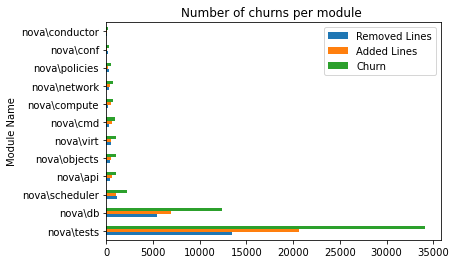

In [167]:
df_churn12[["Module","Removed Lines", "Added Lines", "Churn"]].plot.barh(
    x= 'Module',
    xlabel='Module Name',
    ylabel='Churn',
    title='Number of churns per module '
)

plt.show()

Top 12 modules based on number of commits to each module is shown in the data frame below

In [171]:
df_commit12 = df_path.sort_values(by=['Commits'], ascending = False).head(12)
df_commit12

,Module,Date,File Name,Commits,Added Lines,Removed Lines,Churn
18,nova\tests,2021-05-10 15:04:31-04:00,test_utils.py,200,20648,13449,34097
7,nova\db,2021-06-16 10:10:27+01:00,migration.py,38,6899,5487,12386
19,nova\virt,2021-05-26 17:26:05+01:00,config.py,34,478,531,1009
3,nova\compute,2021-06-01 11:29:38-03:00,manager.py,32,550,221,771
9,nova\network,2021-05-12 10:50:52+08:00,neutron.py,21,437,276,713
1,nova\api,2021-06-09 22:20:38+00:00,requestlog.py,21,670,373,1043
11,nova\objects,2021-05-20 16:57:24+01:00,image_meta.py,21,580,449,1029
2,nova\cmd,2021-05-12 10:50:52+08:00,common.py,16,686,267,953
16,nova\scheduler,2021-06-01 15:11:50+01:00,availability_zone_filter.py,14,1114,1133,2247
5,nova\conf,2021-05-19 10:29:56+02:00,libvirt.py,13,105,216,321


Using Pandas and matplotlib, chart for number of commits per modules is demonstrated:

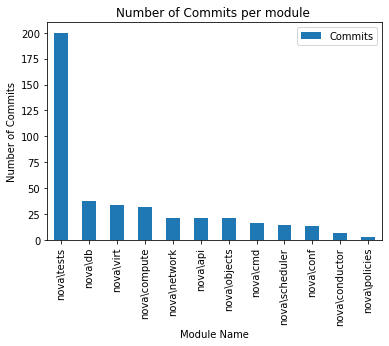

In [173]:
df_commit12[["Module","Commits"]].plot.bar(
    x= 'Module',
    xlabel='Module Name',
    ylabel='Number of Commits',
    title='Number of Commits per module '
)

plt.show()